Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. For an in-depth tutorial, refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/examples/mit_reactor.html) notebook. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# Reactor Physics

**Inputs**: 2-group homogenized cross sections (HXS) ($cm^{-1}$)

- `FissionFast`: $\nu\Sigma_f^1$
- `CaptureFast`: $\Sigma_a^1$
- `FissionThermal`: $\nu\Sigma_f^2$
- `CaptureThermal`: $\Sigma_a^2$
- `Scatter12`: $\Sigma_s^{1 \rightarrow 2}$
- `Scatter11`: $\Sigma_s^{1 \rightarrow 1}$
- `Scatter21`: $\Sigma_s^{2 \rightarrow 1}$
- `Scatter22`: $\Sigma_s^{2 \rightarrow 2}$

**Outputs**

- `k`: Neutron multipulcation factor

This data set consists of 1000 observations with 8 inputs and 1 output. The data is taken from [[RSOGradyK19]](https://pymaise.readthedocs.io/en/stable/index.html#id3), a sensitivity analysis using the Shapley effect. The geometry of the problem is a pressurized water reactor (PWR) lattice based on the BEAVRS benchmark. The lattice is a $17 \times 17$ PWR with $264~UO_2$ fuel rods, 24 guide tubes, and one instrumentation tube. The lattice utilizes quarter symmetry in TRITON and is depleted to $50~GWD/MTU$. To construct the data set, a two-step process was used: (1) the uncertainty in the fundamental microscopic XS data was propagated, and (2) these XSs were collapsed into a 2-group form using the following equation

\begin{equation}
\Sigma_x^g = \frac{\int_{\Delta E_g}dE \int_V \Sigma_{x,m}(E) \phi(r,E,t) dV}{\int_{\Delta E_g}dE\int_V\phi(r,E,t)dV}.
\end{equation}

The sampler module in SCALE was used for uncertainty propagation, and the 56-group XS and covariance libraries were used in TRITON to create 56-group HXSs using the above equation. These HXSs are then collapsed into a 2-group library. 1000 random samples were taken from the Sampler [[RSOGradyK19]](https://pymaise.readthedocs.io/en/stable/index.html#id3).

To start pyMAISE the general packages are imported below.

In [22]:
from pyMAISE.datasets import load_xs
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization
We can load the reactor physics preprocessor by `pyMAISE.datasets.load_xs()` and with defining the it is a regression problem below.

In [23]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)
data, inputs, outputs = load_xs()

The data consists of 8 inputs:

In [24]:
inputs

<xarray.DataArray (index: 1000, variable: 8)>
array([[0.0064462 , 0.00924782, 0.130007  , ..., 0.482483  , 0.00150595,
        1.12546   ],
       [0.00635893, 0.00934703, 0.128811  , ..., 0.490558  , 0.00149675,
        1.12616   ],
       [0.0064674 , 0.00925333, 0.129465  , ..., 0.486784  , 0.00149345,
        1.12423   ],
       ...,
       [0.00649919, 0.00934518, 0.129862  , ..., 0.490898  , 0.00151782,
        1.1289    ],
       [0.00647664, 0.00944998, 0.130726  , ..., 0.494716  , 0.0015138 ,
        1.12734   ],
       [0.0062723 , 0.00960541, 0.130317  , ..., 0.502067  , 0.00150592,
        1.1264    ]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'FissionFast' 'CaptureFast' ... 'Scatter22'

and one output with 1000 data points:

In [25]:
outputs

<xarray.DataArray (index: 1000, variable: 1)>
array([[1.256376],
       [1.241534],
       [1.256988],
       [1.261442],
       [1.253744],
       [1.261324],
       [1.246886],
       [1.249954],
       [1.25212 ],
       [1.258008],
       [1.256793],
       [1.247149],
       [1.253193],
       [1.249416],
       [1.24956 ],
       [1.246953],
       [1.248573],
       [1.261022],
       [1.247053],
       [1.249361],
...
       [1.256116],
       [1.239636],
       [1.269848],
       [1.249036],
       [1.24979 ],
       [1.262373],
       [1.256964],
       [1.246652],
       [1.250859],
       [1.251616],
       [1.251508],
       [1.25897 ],
       [1.259301],
       [1.247735],
       [1.244721],
       [1.256407],
       [1.24553 ],
       [1.251895],
       [1.255878],
       [1.240064]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'k'

To get a better idea of the data we can create a corrilation matrix using the `pyMAISE.preprocessing.correlation_matrix()` function.

(<Figure size 800x800 with 2 Axes>, <Axes: >)

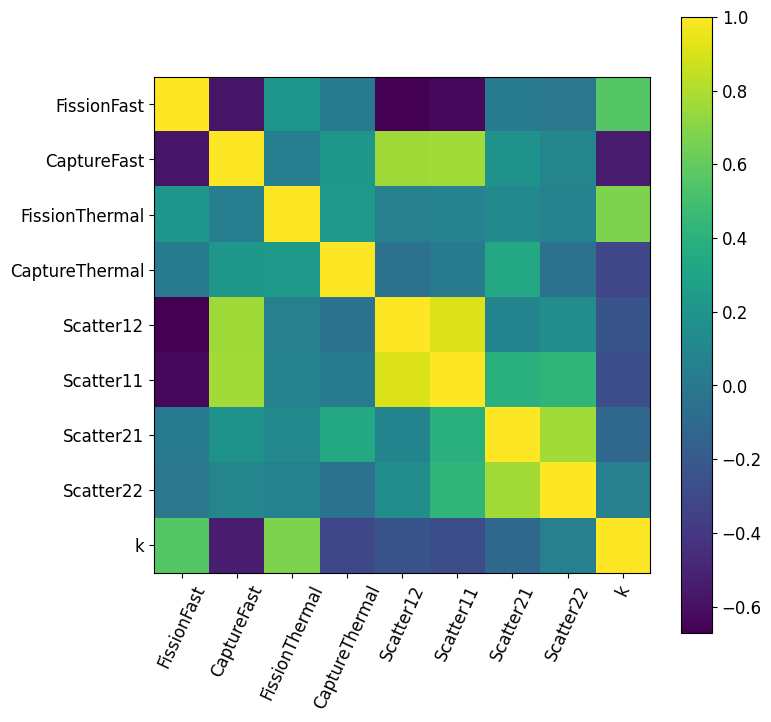

In [26]:
correlation_matrix(data)

There is a positive correlation between `k` with `FissionFast` and `FissionThermal`. There is also a strong negative correlation of `k` with `CaptureFast`.

The last step is to preprocess the data by scaling. We will min-max scale this data.

In [27]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 7 regression models in this data set:

- linear: `Linear`,
- lasso: `Lasso`,
- support vector machine: `SVM`,
- decision tree: `DT`,
- random forest: `RF`,
- k-nearest neighbors regression: `KN`,
- dense feedforward neural network: `FNN`.

For hyperparameter tuing, we initialize all classical models as scikit-learn defaults. For the FNN we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, use of sublayer, and the rate of dropout. The dense hidden layers include tuning of their depth.

In [28]:
model_settings = {
    "models": ["Linear", "Lasso", "SVM", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=250),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

The hyperparameter tuning spaces are defined below. We use random search for the classical models as their training is quick and random search can cover a large parameter space. Bayesian search is used for the FNNs as their training is more computationally expensive. Both search methods use 5-fold cross-validation to mitigate bias from the training data. We train 200 classical models from random search and 50 iterations of Bayesian search for neural networks. 

In [29]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "SVM": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 50 Complete [00h 00m 16s]
r2_score: 0.9334333919742279

Best r2_score So Far: 0.9997043125208128
Total elapsed time: 00h 11m 41s
Hyperparameter tuning took 15.350643932819366 minutes to process.


We can now see the Bayesian search hyperparameter optimization in the convergence plot.

(0.0, 1.0)

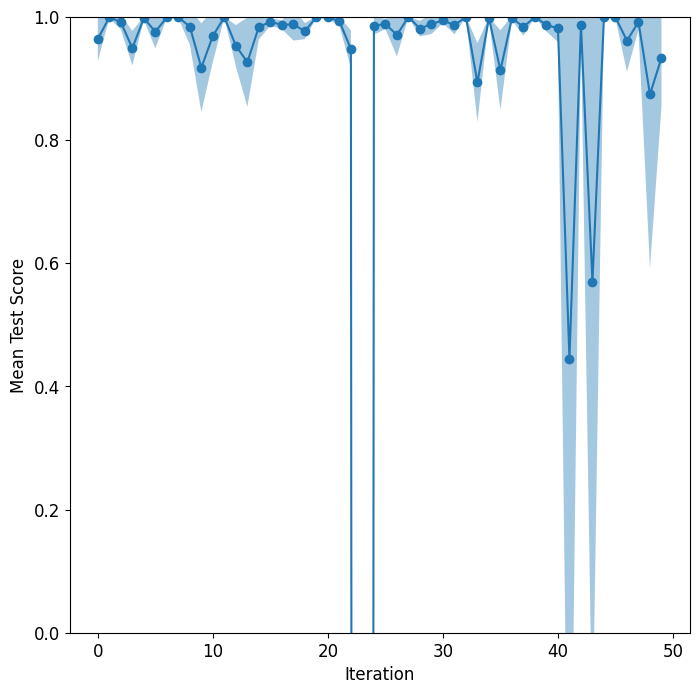

In [30]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])

## Model Postprocessing

With the top `pyMAISE.Settings.num_configs_saved`, we can pass these parameter configurations to the `pyMAISE.PostProcessor` for model comparison and analysis. For the FNNs we define the `"epochs"` parameter to be 200 for better performance.

In [31]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

To compare the performance of these models we will compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\bar{y}$ is the model predicted outcome, and $n$ is the number of observations. Metrics for `k` are shown below.

In [32]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.999932,0.000043,3.811626e-09,0.000062,0.999917,0.000044,4.058017e-09,0.000064
29,FNN,"{'Dense_input_0_units': 80, 'Dense_hidden_num_...",0.999920,0.000048,4.483079e-09,0.000067,0.999848,0.000052,7.412273e-09,0.000086
30,FNN,"{'Dense_input_0_units': 228, 'Dense_hidden_num...",0.999874,0.000065,7.058245e-09,0.000084,0.999825,0.000068,8.485293e-09,0.000092
28,FNN,"{'Dense_input_0_units': 313, 'Dense_hidden_num...",0.999882,0.000056,6.586589e-09,0.000081,0.999810,0.000057,9.251879e-09,0.000096
27,FNN,"{'Dense_input_0_units': 109, 'Dense_hidden_num...",0.999904,0.000052,5.386066e-09,0.000073,0.999769,0.000057,1.124309e-08,0.000106
1,Lasso,{'alpha': 0.00010491036846985312},0.999740,0.000096,1.452482e-08,0.000121,0.999725,0.000086,1.339149e-08,0.000116
26,FNN,"{'Dense_input_0_units': 223, 'Dense_hidden_num...",0.999621,0.000131,2.120041e-08,0.000146,0.999360,0.000135,3.110276e-08,0.000176
2,Lasso,{'alpha': 0.0001938760041690547},0.999292,0.000161,3.954940e-08,0.000199,0.999295,0.000141,3.427805e-08,0.000185
3,Lasso,{'alpha': 0.000216603703677193},0.999136,0.000178,4.829901e-08,0.000220,0.999145,0.000156,4.158149e-08,0.000204
4,Lasso,{'alpha': 0.00029937508638317134},0.998419,0.000241,8.836074e-08,0.000297,0.998457,0.000212,7.499334e-08,0.000274


The top performing models based on test $R^2$ are linear regression, lasso regression, and the FNNs. This indicates a very linear data set. K-nearest neighbors, random forest, and decision tree overfit to the training data.

The hyperparameter configurations of the top performing models are listed below.

In [33]:
for model in ["Lasso", "SVM", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.00010491036846985312

Model Types: SVM
degree: 2
gamma: scale
kernel: poly

Model Types: DT
max_depth: 12
max_features: 6
min_samples_leaf: 5
min_samples_split: 2

Model Types: RF
criterion: absolute_error
max_features: 4
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 77

Model Types: KN
leaf_size: 8
n_neighbors: 5
p: 3
weights: distance

Model Types: FNN
Dense_input_0_units: 80
Dense_hidden_num_layers: 1
Adam_learning_rate: 0.0002630991713257198
Dense_hidden_0_units: 95
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.5841694379147954
batch_size: 16
Dense_hidden_1_units: 152
Dense_hidden_1_sublayer: Dropout_hidden
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.4234555474745452
Dense_hidden_2_units: 130
Dense_hidden_2_sublayer: None
Dense_hidden_2_sublayer_Dropout_hidden_0_rate: 0.5634095581458857



We can better visualize the performance of each model with diagonal validation plots.

Text(0.5, 1.0, 'FNN')

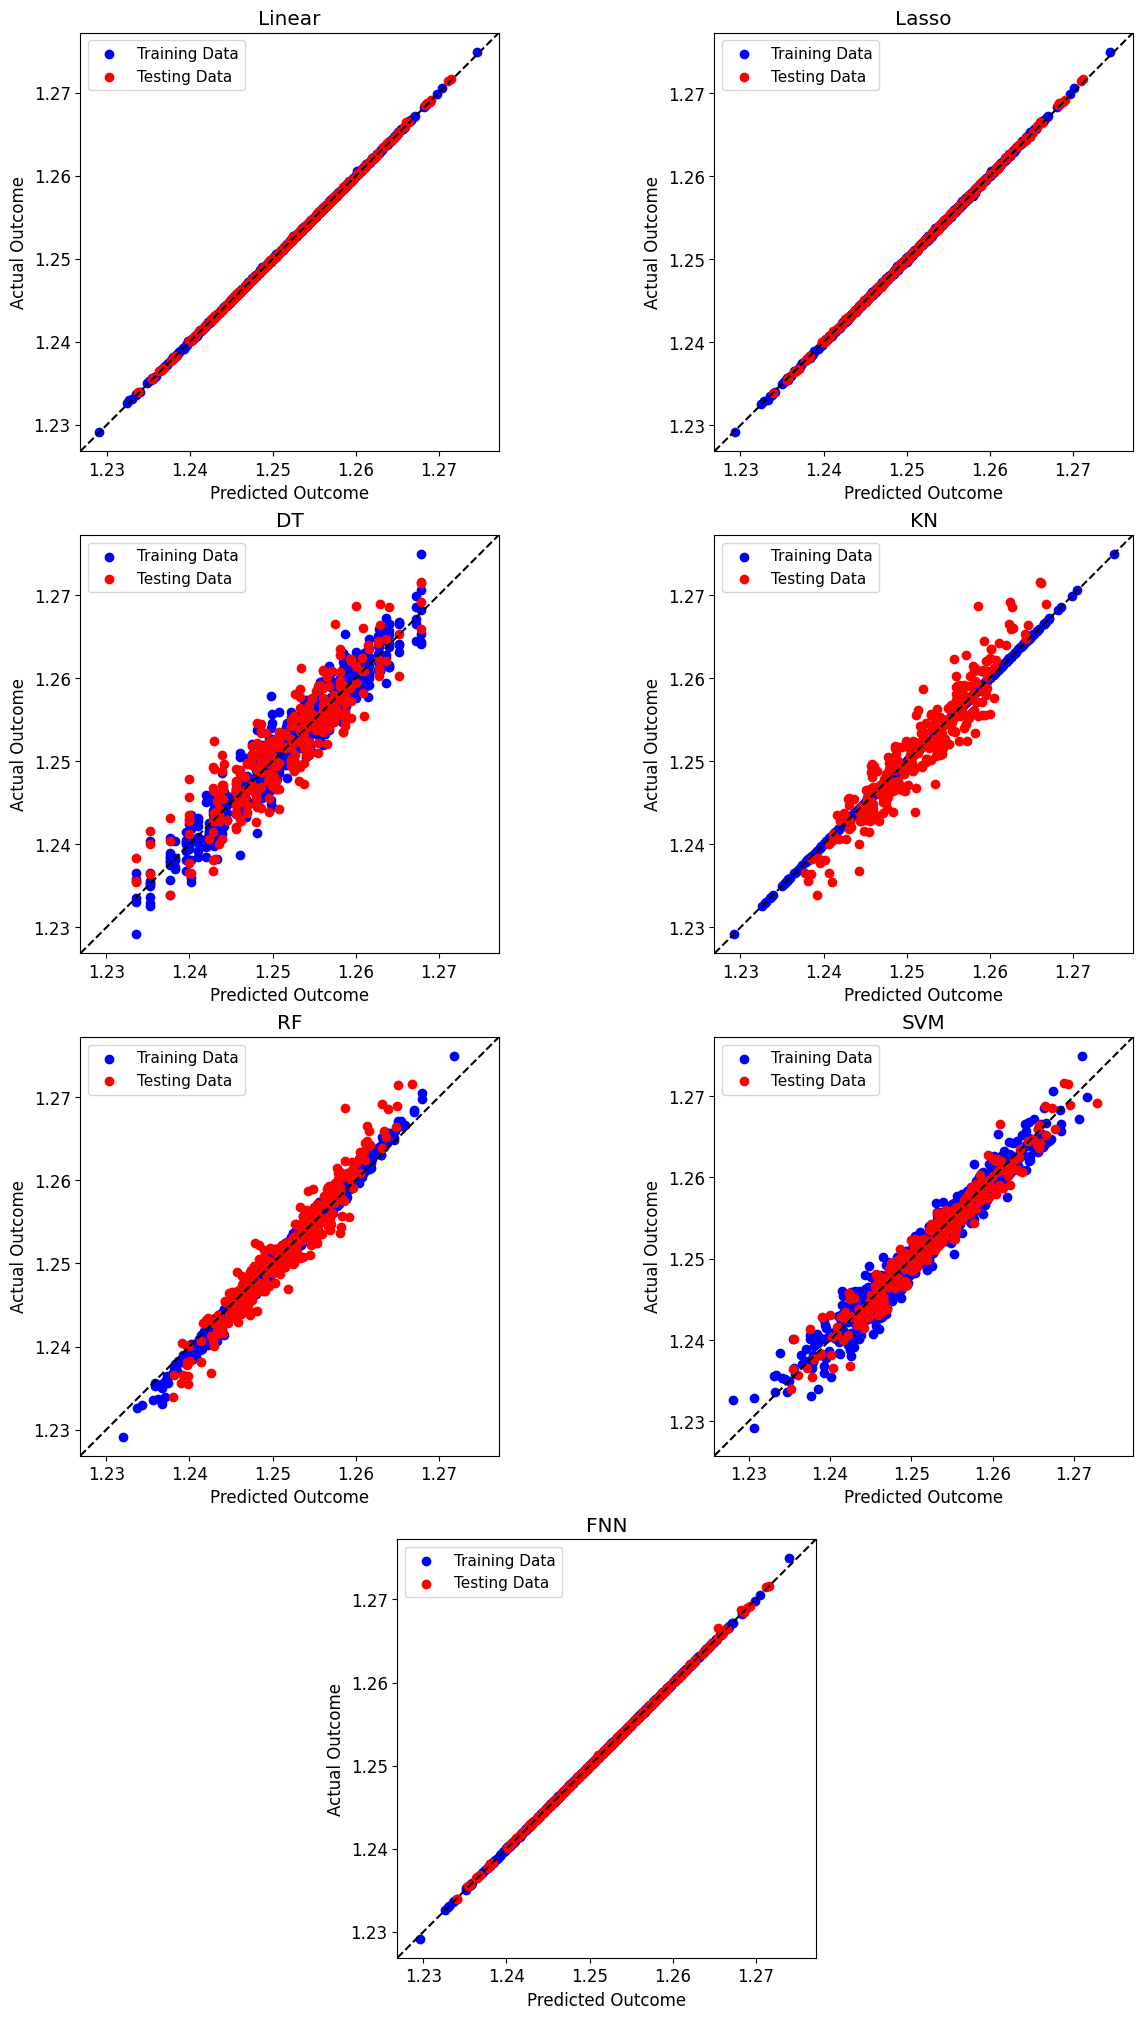

In [34]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "SVM"]])
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.diagonal_validation_plot(model_type="FNN")
ax.set_title("FNN")

Linear regression, lasso regression, and FNN are tightly spread near $y = x$. The overfit of k-nearest neighbors is apparent given the difference in spread of trianing compared to testing data.

Validation plots tell us a similar story.

Text(0.5, 1.0, 'FNN')

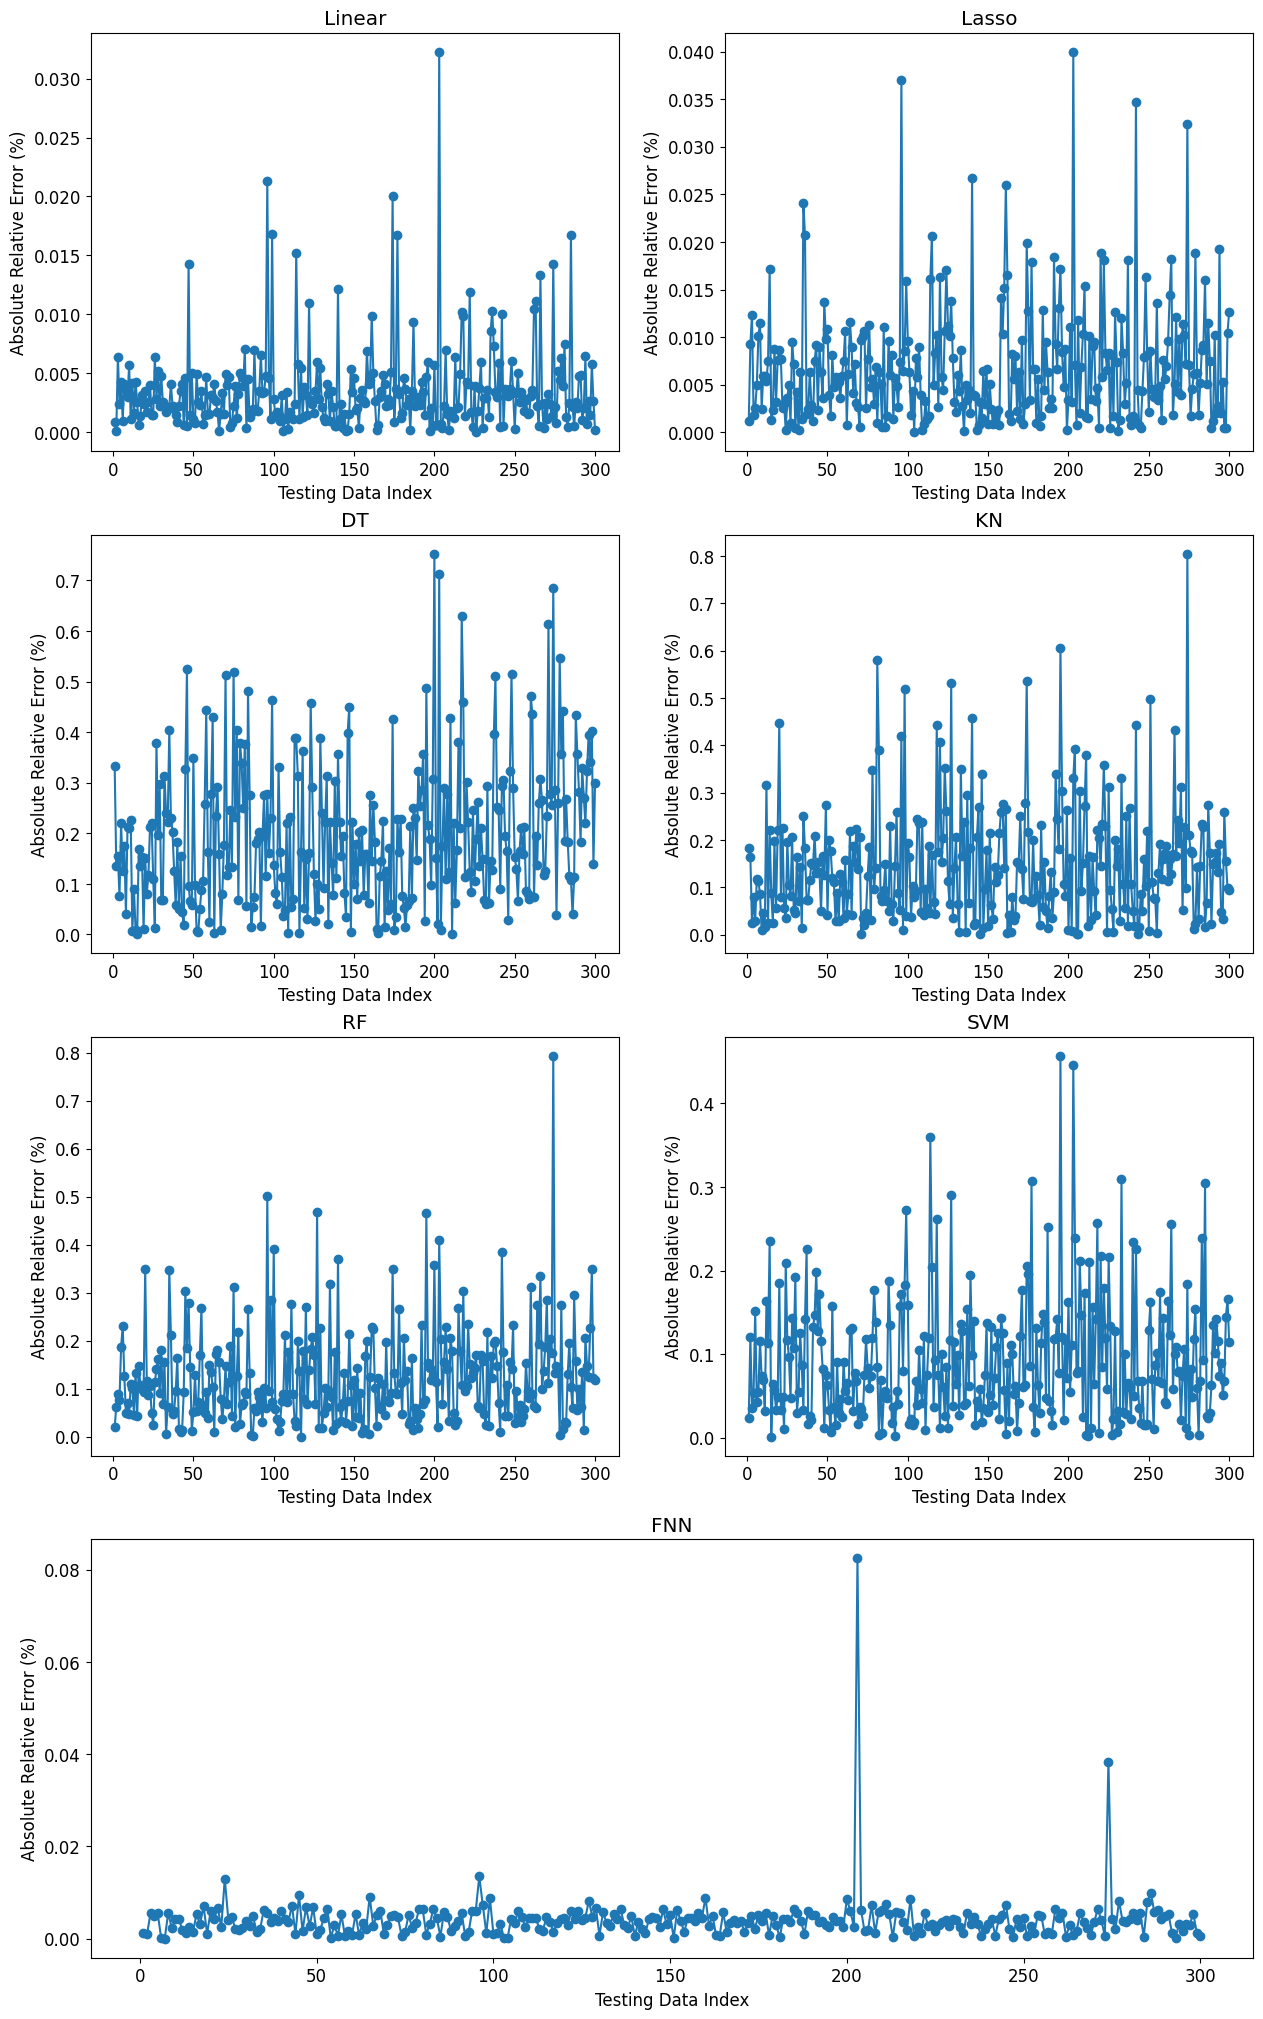

In [35]:
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.validation_plot(model_type="FNN")
ax.set_title("FNN")

Linear regression, lasso regression, and FNN all have testing relative errors less than 0.15.

Finally, we can see if the FNN is overfit based on its learning curve.

<Axes: xlabel='Epoch', ylabel='Loss'>

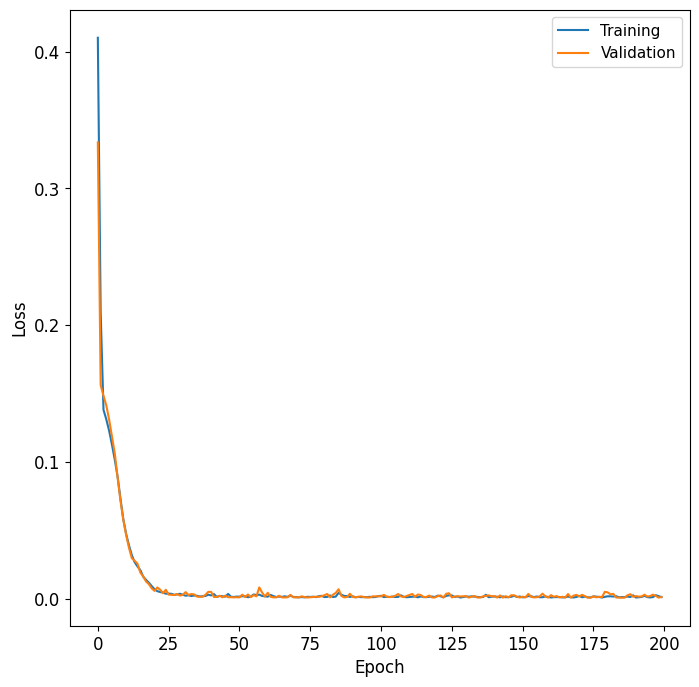

In [36]:
postprocessor.nn_learning_plot()

The validation curve is below the training curve; therefore, the best FNN based on test $R^2$ was not overfit.

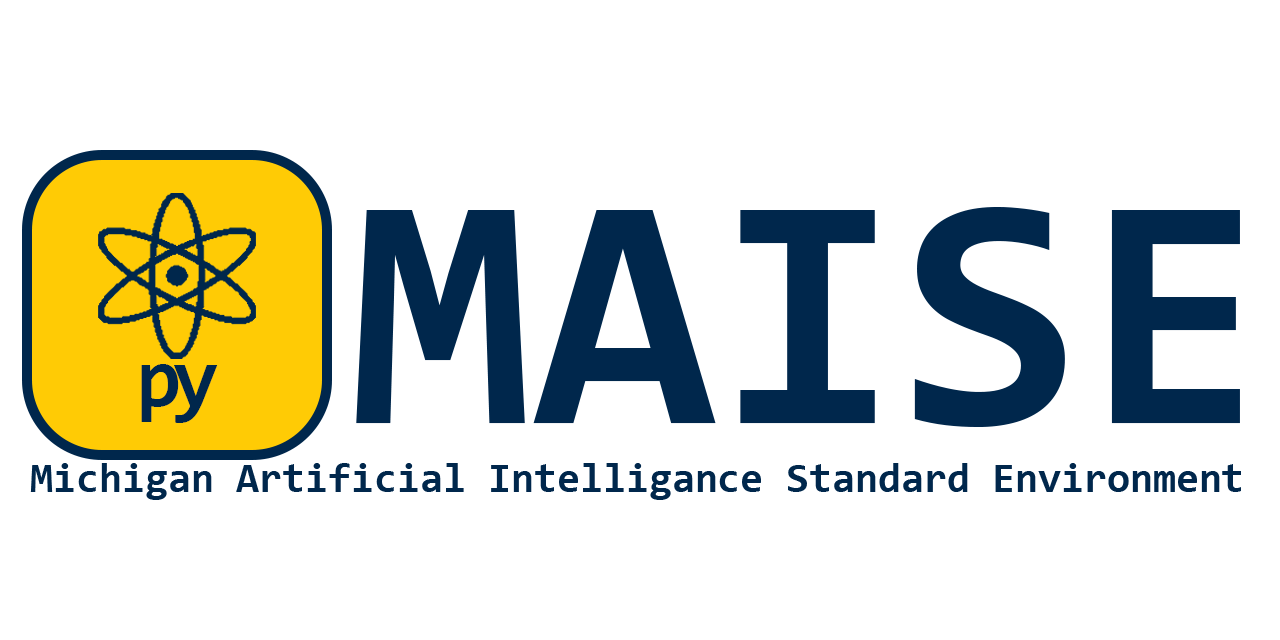